In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome


In [5]:
def get_robot(genome, robot_size, neat_config):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(robot_size)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, robot_size)
        print(robot)

    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)

    
    env = DynamicObstacleTraverser(body=robot, connections=connections, filename="../dynamic_env/env.json")
    img = env.render(mode='img')
    env.close()
    return robot, img

In [6]:
# STEPS = 400
# ROBOT_SIZE = 5
# POP = 48

# directory = "results/" + ENV

# params = {"robot_size": ROBOT_SIZE, "env": "dynamic", "steps": STEPS, "pop_size": POP}

# morphology_coords = morph_substrate(ROBOT_SIZE)
# CustomGenome.robot_func = lambda self, net, params: generate_robot(net, ROBOT_SIZE)
# CustomGenome.substrate = morphology_coords
# CustomGenome.robot_size = ROBOT_SIZE


# neat_config = neat.config.Config(
#     CustomGenome,
#     neat.reproduction.DefaultReproduction, 
#     neat.species.DefaultSpeciesSet, 
#     neat.stagnation.DefaultStagnation, 
#     "../configs/POET.cfg"
# )

# input_size = morphology_coords.dimensions*2 + 1 # two coordinates plus the bias
# neat_config.genome_config.num_inputs = input_size
# neat_config.genome_config.input_keys = [-1*i for i in range(1, input_size+1)]
# neat_config.genome_config.num_outputs = 1
# neat_config.genome_config.output_keys = [1]

with open(f"../poet/cp_gen_40.pkl", "rb") as file:
    poet_pop = pkl.load(file)



###################### Pair (0, 0) ########################

7090 0.33337155631045445


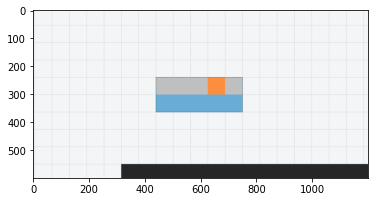

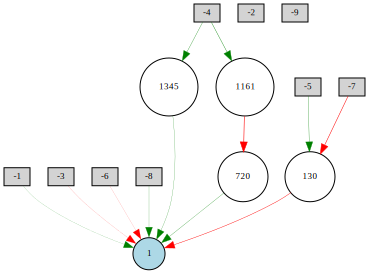

7694 0.36050529051674923


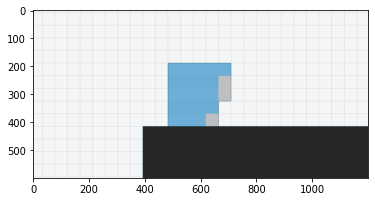

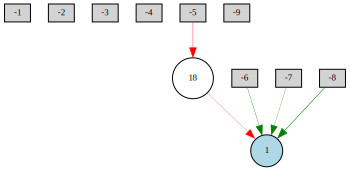

6626 0.36323591206155686


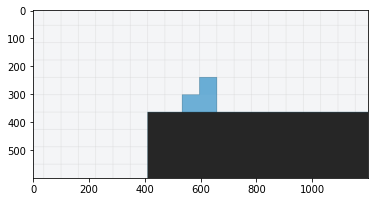

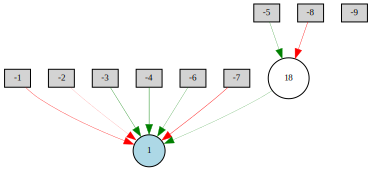

7230 0.5834508682079534


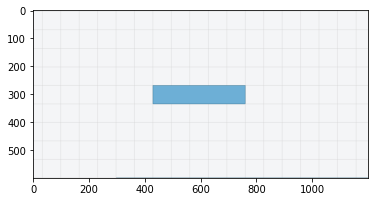

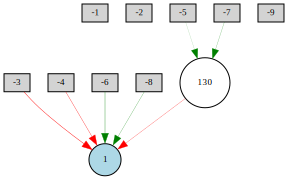

7148 1.2004170673809393


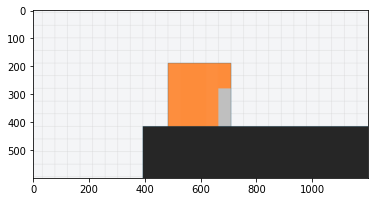

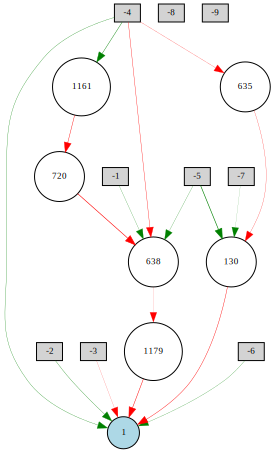

7826 1.5368700452508013


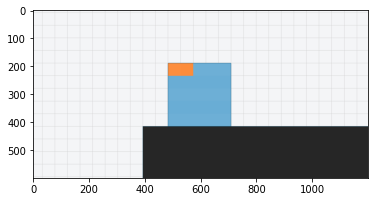

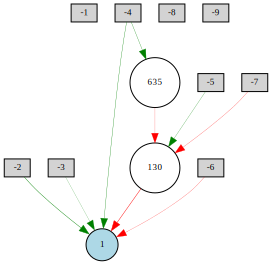

7724 2.1137358893098765


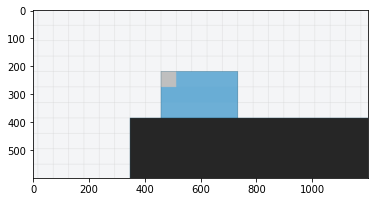

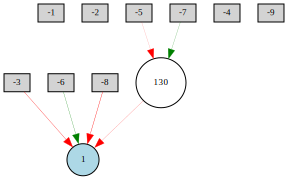

4898 3.8678410591262042


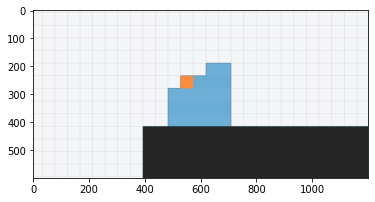

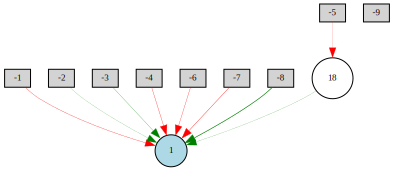



###################### Pair (1, 1) ########################

7808 0.31597167856120156


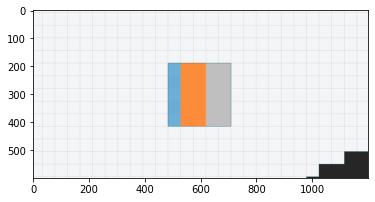

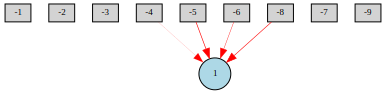

7561 0.36701877497794877


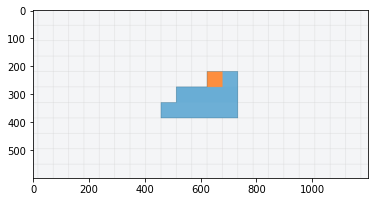

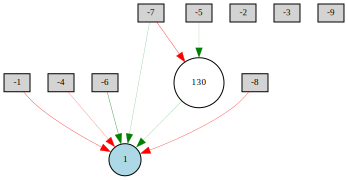

7480 0.4726200580769401


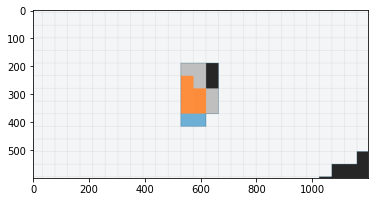

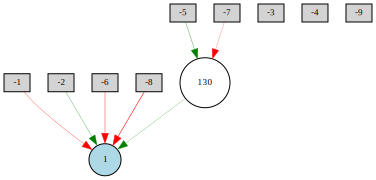

7292 0.5318149007913976


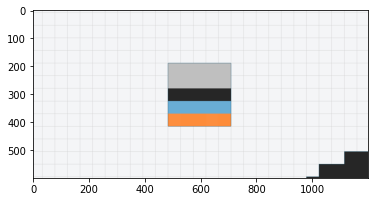

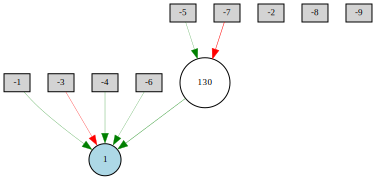

3243 0.897991356474404


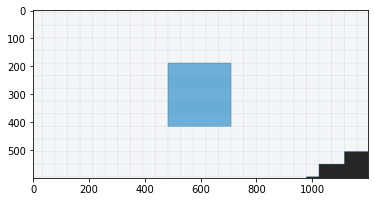

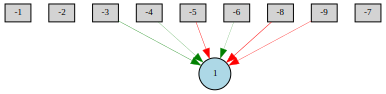



###################### Pair (5, 1) ########################

7323 0.30398259511680575


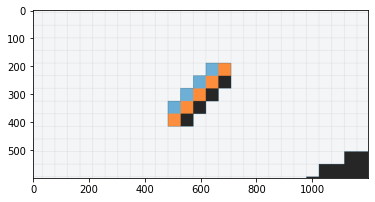

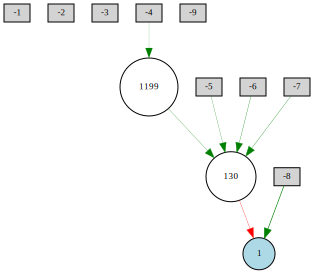

7247 0.38918388082584343


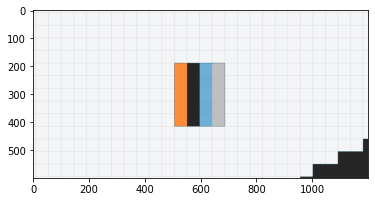

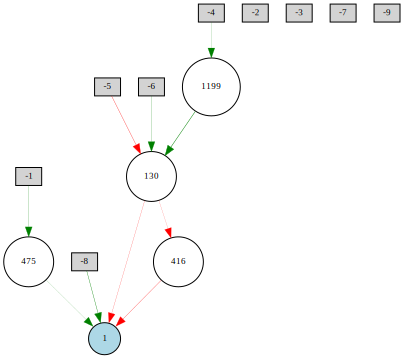

7044 0.3939434345492868


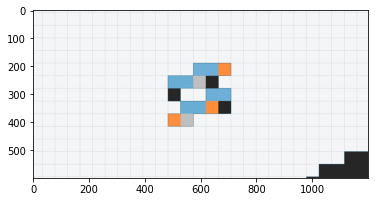

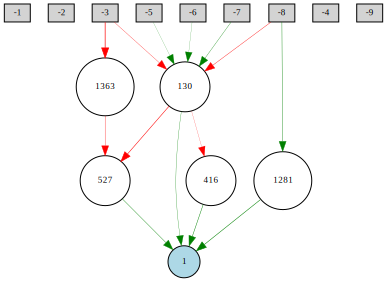

7054 0.4863414598537704


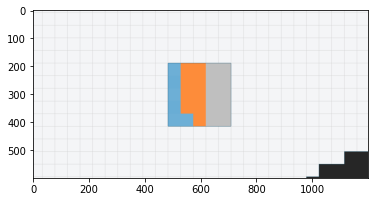

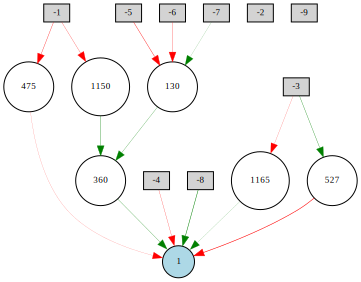

7383 0.5299008058607444


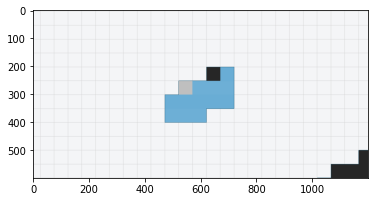

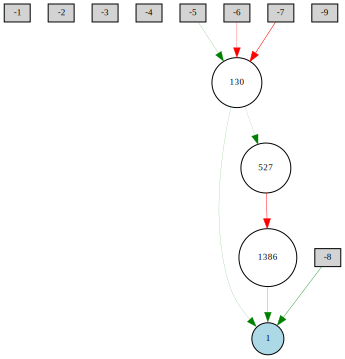

6991 0.5445628592245062


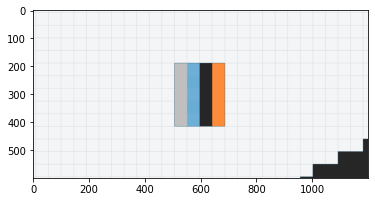

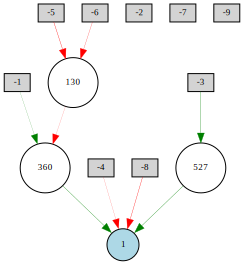

7397 0.5767810326426468


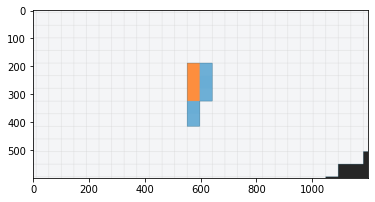

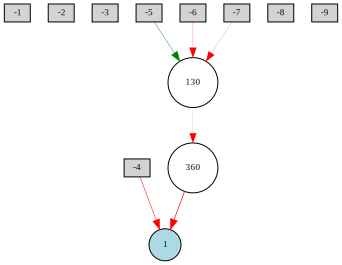

7233 0.6006284781075976


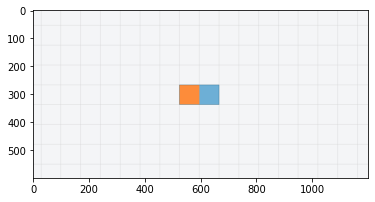

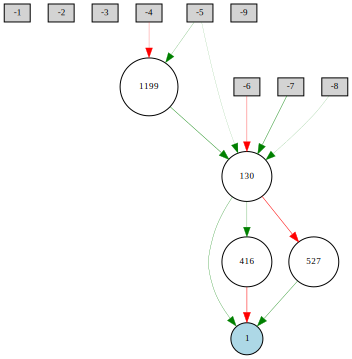

7227 0.6971215487548845


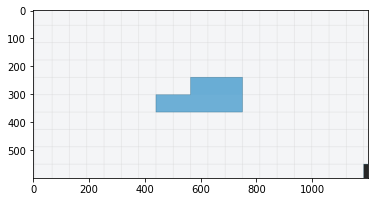

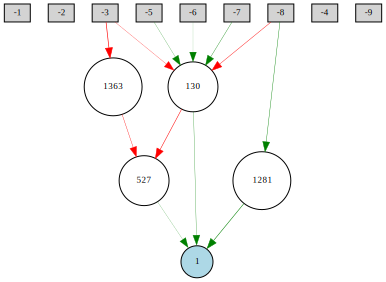

1921 0.8937169054825758


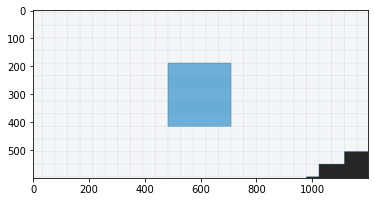

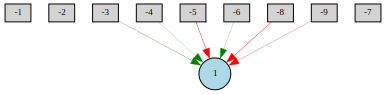

In [18]:
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    print(f"\n\n###################### Pair ({env.id}, {pop.id}) ########################\n")
    env.generate_json("env.json")
    for ag_id, ag in pop.pop.population.items():
        if ag.fitness is not None and ag.fitness > .2:
            r, img = get_robot(ag, pop.robot_size, pop.neat_config)
            if img is not None:
                print(ag.key, ag.fitness)
                plt.imshow(img)
                plt.show()
                net = neat.nn.FeedForwardNetwork.create(ag, pop.neat_config)
                display(draw_net(net))

In [55]:
STEPS = 400
env_dict = {}
ag_dict = {}
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    for ag_id, ag in pop.pop.population.items():
        ag_dict[ag_id] = (ag, pop)
    env_dict[env.id] = env



In [56]:
def show_exec(ag_id, env_id):
    env_dict[env_id].generate_json("env.json")
    ag, pop = ag_dict[ag_id]
    reward, done = pop.single_genome_fit(ag, STEPS, "dynamic", True, None)
    return reward, done

In [58]:
r, d = show_exec(6991, 0)
print(r)

{'key': 6991, 'connections': {(-1, 1): <neat.genes.DefaultConnectionGene object at 0x7f00995db710>, (-3, 1): <neat.genes.DefaultConnectionGene object at 0x7f00995db750>, (-4, 1): <neat.genes.DefaultConnectionGene object at 0x7f00995db790>, (-8, 1): <neat.genes.DefaultConnectionGene object at 0x7f00995db7d0>, (-5, 130): <neat.genes.DefaultConnectionGene object at 0x7f00995db810>, (130, 1): <neat.genes.DefaultConnectionGene object at 0x7f00995db850>, (-7, 130): <neat.genes.DefaultConnectionGene object at 0x7f00995db890>, (-1, 360): <neat.genes.DefaultConnectionGene object at 0x7f00995db8d0>, (360, 1): <neat.genes.DefaultConnectionGene object at 0x7f00995db910>, (-1, 475): <neat.genes.DefaultConnectionGene object at 0x7f00995db950>, (475, 1): <neat.genes.DefaultConnectionGene object at 0x7f00995db990>, (-3, 527): <neat.genes.DefaultConnectionGene object at 0x7f00995db9d0>, (527, 1): <neat.genes.DefaultConnectionGene object at 0x7f00995dba10>, (-6, 130): <neat.genes.DefaultConnectionGene o

In [24]:
print(env_dict[5].barrier_h)

1
